In [1]:
import torch
import torch.nn as nn

class DP_GSD(nn.Module):

    def __init__(self):
        super(DP_GSD, self).__init__()
        
        self.flat = nn.Flatten()
        self.l1 = nn.Linear(784, 392)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(392, 10)
        self.sm = nn.Softmax()

    def forward(self, x):
        
        x = self.flat(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.sm(x)
        
        return x

In [2]:
MAX_GRAD_NORM = 1.2
EPSILON = 50.0
DELTA = 1e-5
EPOCHS = 10

LR = 1e-3

BATCH_SIZE = 512
MAX_PHYSICAL_BATCH_SIZE = 128

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms


DATA_ROOT = '../mnist'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(
    root=DATA_ROOT, train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
)

test_dataset = MNIST(
    root=DATA_ROOT, train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print(len(train_dataset))
dataiter = iter(train_loader)
images, labels = next(dataiter)
images[0].size()

60000


torch.Size([1, 28, 28])

In [4]:
model = DP_GSD()

from opacus.validators import ModuleValidator

model = ModuleValidator.fix(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

ModuleValidator.validate(model, strict=False)

[]

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR)

def accuracy(preds, labels):
    return (preds == labels).mean()

from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

#model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
#    module=model,
#    optimizer=optimizer,
#    data_loader=train_loader,
#    epochs=EPOCHS,
#    target_epsilon=EPSILON,
#    target_delta=DELTA,
#    max_grad_norm=MAX_GRAD_NORM,
#)

#print(f"Using sigma={optimizer.noise_multiplier} and C={MAX_GRAD_NORM}")

/home/knil/Documents/NextCloud/RAstuff/opacus/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


## Everything from here is basically the same as from the opacus tutorial

In [6]:
import numpy as np
import torch.optim as optim
from opacus.utils.batch_memory_manager import BatchMemoryManager


def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []
    
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            optimizer.step()
            

            if (i+1) % 200 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    f"(ε = {epsilon:.2f}, δ = {DELTA})"
                )
    return acc, epsilon
    

In [7]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)


from tqdm.notebook import tqdm

report = []

#for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
#    results = train(model, train_loader, optimizer, epoch + 1, device)
#    report.append(results)

In [8]:
acc = []
e = []
for i in report:
    acc.append(i[0])
    e.append(i[1])

In [9]:
from opacus import PrivacyEngine
runs = []
trun = []
for i in range(18,101):
    model = DP_GSD()
    from opacus.validators import ModuleValidator

    model = ModuleValidator.fix(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    
    privacy_engine = PrivacyEngine(accountant = 'rdp_plrv')
    
    optimizer = optim.RMSprop(model.parameters(), lr=LR)

    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier = 1,
        epochs=EPOCHS,
        target_epsilon=i,
        target_delta=DELTA,
        max_grad_norm=1,
    )
    
    report = []

    #for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    results = train(model, train_loader, optimizer, 1, device)
    #report.append(results)
    
    runs.append(report)
    trun.append(test(model, test_loader, device))
    del model
    del optimizer
    del results
    torch.cuda.empty_cache()

/home/knil/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/knil/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/knil/Documents/NextCloud/RAstuff/opacus/opacus/accountants/analysis/rdp_plrv.py:132: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


	Train Epoch: 1 	Loss: 2.301134 Acc@1: 14.119943 (ε = 2.77, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.300421 Acc@1: 14.159026 (ε = 5.18, δ = 1e-05)
	Test set:Loss: 2.299278 Acc: 13.885570 
	Train Epoch: 1 	Loss: 2.302017 Acc@1: 8.913392 (ε = 2.90, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.301294 Acc@1: 9.987082 (ε = 5.45, δ = 1e-05)
	Test set:Loss: 2.299485 Acc: 12.285156 



KeyboardInterrupt



In [ ]:
report

In [ ]:
import matplotlib.pyplot as plt
labels = [0.2, 0.3, 0.5, 1, 2]
for j in range(len(runs)):
    acc = []
    e = []
    for i in runs[j]:
        acc.append(i[0])
        e.append(i[1])
    
    plt.plot(range(10), e, label=labels[j])
    
plt.legend(loc="lower right")
plt.xticks(range(10))
plt.xlabel("Epoch")
plt.ylabel("Epsilon")
plt.title("Training Accuracy per Epoch for different values of Maximum Epsilon")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
labels = [0.2, 0.3, 0.5, 1, 2]
for j in range(len(runs)):
    acc = []
    e = []
    for i in runs[j]:
        acc.append(i[0])
        e.append(i[1])
    
    plt.plot(range(10), e, label=labels[j])
    
plt.legend(loc="lower right")
plt.xticks(range(10))
plt.xlabel("Epoch")
plt.ylabel("Epsilon")
plt.title("Training Accuracy per Epoch for different values of Maximum Epsilon")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
labels = ["run 1","run 2","run 3","run 4","run 5"]
for j in range(len(runs)):
    acc = []
    e = []
    for i in runs[j]:
        acc.append(i[0])
        e.append(i[1])
    
    plt.plot(acc, e, label=labels[j])
    
plt.legend(loc="lower right")
#plt.xticks(range(10))
plt.xlabel("Accuracy")
plt.ylabel("Epsilon")
plt.title("Training Accuracy per Epoch for different values of Maximum Epsilon")
plt.show()

In [ ]:
x = range
y=[]
for i in runs:
    y.append(i[-1][0])

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Final Accuracy vs Epsilon")
plt.plot(x, trun, 'ro-', label="Testing Acc")
plt.legend(loc="lower right")
plt.show()

In [ ]:
runs = []
trun = []

for i in [0.2, 0.3, 0.5, 1, 2]:
    model = DP_GSD()

    from .opacus.validators import ModuleValidator

    model = ModuleValidator.fix(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    
    privacy_engine = PrivacyEngine()
    
    optimizer = optim.RMSprop(model.parameters(), lr=LR)

    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=i,
        target_epsilon=1,
        target_delta=DELTA,
        max_grad_norm=2,
    )
    
    report = []

    for epoch in tqdm(range(i), desc="Epoch", unit="epoch"):
        results = train(model, train_loader, optimizer, epoch + 1, device)
        report.append(results)
    
    runs.append(report)
    trun.append(test(model, test_loader, device))
    del model

In [ ]:
x = [0.2, 0.3, 0.5, 1, 2]
y=[]
for i in runs:
    y.append(i[-1][0])

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
#plt.title("Final Accuracy vs Epochs with Epsilon = 2")
plt.plot(x, y, 'bo-', label="Training Acc")
plt.plot(x, trun, 'ro-', label="Testing Acc")
plt.legend(loc="lower right")
plt.show()

In [ ]:
import torch

In [17]:
from opacus.optimizers.optimizer import _check_processed_flag, _mark_as_processed, DPOptimizer
from torch.distributions.laplace import Laplace
from torch.distributions.gamma import Gamma
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch import stack, zeros, einsum
from opacus.optimizers.utils import params
from torch import nn
from torch.optim import Optimizer
from scipy.stats import truncnorm, expon

class PLRVDPOptimizer():
    """
    Implementation of PLRV first noise mechanism.
    """
        
    def make_noise(self, args):
        self.args = args
        self.k = self.args['k']
        self.theta = self.args['theta']
        self.mu = self.args['mu']
        self.sigma = self.args['sigma']
        self.a = self.args['a']
        self.b = self.args['b']
        self.l = self.args['l']
        self.u = self.args['u']
        self.clip = self.args['max_grad_norm']
        self.lam = self.args['lam']
        
        a_transformed, b_transformed = (self.l - self.mu) / self.sigma, (self.u - self.mu) / self.sigma
        
        self.gamma = Gamma(
          concentration = self.k, rate = self.theta
          )
        self.normal= truncnorm(
          a_transformed, b_transformed, loc=self.mu, scale=self.sigma
          )
        self.uniform = Uniform(
          low = self.a, high = self.b
          )
        self.expon = expon(loc=0, scale = 1/self.lam)
    
    
    def add_noise(self):
          
        for p in self.params:
            _check_processed_flag(p.summed_grad)
            
            laplace = self.get_laplace()
            noise = laplace.sample(p.summed_grad.shape).to(p.summed_grad.device)
            p.grad = p.summed_grad + noise

            _mark_as_processed(p.summed_grad)
            
    def get_linear_combination(self):
        gam = self.gamma.sample()
        uni = self.uniform.sample()
        t_norm = self.normal.rvs(size=1)[0]  
        exp = self.expon.rvs(size=1)[0]
        return 1/(self.args['a1']*gam+self.args['a3']*exp+self.args['a4']*uni)
        
    def get_laplace(self):
        return Laplace(loc=0, scale=self.get_linear_combination())
        
    def clip_and_accumulate(self):
        """
        Performs gradient clipping.
        Stores clipped and aggregated gradients into `p.summed_grad```
        """

        if len(self.grad_samples[0]) == 0:
            # Empty batch
            per_sample_clip_factor = zeros(
                (0,), device=self.grad_samples[0].device
            )
        else:
            per_param_norms = [
                g.reshape(len(g), -1).norm(1, dim=-1) for g in self.grad_samples
            ]
            per_sample_norms = stack(per_param_norms, dim=1).norm(1, dim=1)
            per_sample_clip_factor = (
                self.max_grad_norm / (per_sample_norms + 1e-6)
            ).clamp(max=1.0)

        for p in self.params:
            _check_processed_flag(p.grad_sample)
            grad_sample = self._get_flat_grad_sample(p)
            grad = einsum("i,i...", per_sample_clip_factor, grad_sample)

            if p.summed_grad is not None:
                p.summed_grad += grad
            else:
                p.summed_grad = grad

            _mark_as_processed(p.grad_sample)

In [18]:
args ={
            "a1":0.1,
            "a3":0.1,
            "a4":0.1,
            "lam":5,
            "moment":1,
            "theta":0.05,
            'k':1,
            'mu':0,
            'sigma':0.1,
            'a':0,
            'b':1,
            'u':1,
            'l':0.1,
            'epsilon':1,
            'max_grad_norm': 1,
        }

In [26]:
noise = PLRVDPOptimizer()
noise.make_noise(args)
laplace = noise.get_laplace()
laplace.sample((1,1000)).tolist()[0]

[0.058448903262615204,
 -0.21850255131721497,
 -0.3315099775791168,
 0.06761839240789413,
 -0.1973942220211029,
 -0.0727401077747345,
 -0.1249685287475586,
 -0.5004053711891174,
 0.06360744684934616,
 -0.1517011821269989,
 -0.05235239118337631,
 -0.06701188534498215,
 0.1903074085712433,
 -0.08757440000772476,
 -1.046970009803772,
 -0.32570430636405945,
 0.15618322789669037,
 0.2910183370113373,
 0.1246391013264656,
 0.05518228933215141,
 0.36447906494140625,
 -0.17614123225212097,
 -0.06366351246833801,
 0.2361728399991989,
 0.5420812964439392,
 0.1564236730337143,
 -0.009325975552201271,
 0.353128045797348,
 0.03596758097410202,
 0.1528523564338684,
 -0.7325301170349121,
 0.344671368598938,
 -0.3322526514530182,
 -0.4131670594215393,
 -0.1416986733675003,
 0.13912832736968994,
 -0.507836103439331,
 0.09479603171348572,
 -0.11979881674051285,
 0.033522434532642365,
 0.047151919454336166,
 0.1966782510280609,
 -0.04493755102157593,
 -0.3155600428581238,
 -0.27894356846809387,
 0.164619

In [30]:
import matplotlib.pyplot as plt
samples = []
for i in range(1000):
    laplace = noise.get_laplace()
    samples.append(laplace.sample().tolist())
    
print(samples)

[-0.48421669006347656, 6.859867572784424, 1.6153236627578735, -0.07475051283836365, 0.33072999119758606, 2.315701723098755, 0.046478889882564545, 0.48302555084228516, -0.22696922719478607, -2.3006274700164795, -0.05558690428733826, -0.1735842078924179, 0.19283689558506012, 0.4017583727836609, 0.3578544557094574, 1.622477412223816, -0.22785033285617828, 0.5515493750572205, 1.177459716796875, -0.562652587890625, -0.8977635502815247, -0.6049448847770691, -5.232145309448242, 1.268342137336731, -8.87392520904541, 0.6037558913230896, 1.1196857690811157, -1.3673887252807617, -0.3968440592288971, -0.1660827249288559, 0.039844535291194916, -1.0943140983581543, -1.256104588508606, -0.48161032795906067, -3.0165414810180664, 0.3926772475242615, 0.06438491493463516, 6.932007789611816, 5.4418134689331055, -0.5753971934318542, -0.5743585824966431, -0.11227335780858994, -0.416264146566391, -0.3540361523628235, -0.08114197850227356, 0.009076731279492378, 0.9984863996505737, 1.202820062637329, 1.0971018

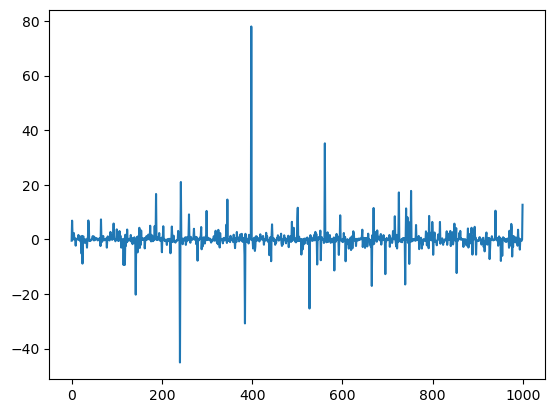

In [31]:
plt.plot(range(1000), samples)
plt.show()

In [38]:
from opacus.optimizers.optimizer import _check_processed_flag, _mark_as_processed, DPOptimizer
from torch.distributions.laplace import Laplace
from torch.distributions.gamma import Gamma
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch import stack, zeros, einsum
from opacus.optimizers.utils import params
from torch import nn
from torch.optim import Optimizer
from scipy.stats import truncnorm, expon

class PLRVDPOptimizer():
    """
    Implementation of PLRV first noise mechanism.
    """
        
    def make_noise(self, args):
        self.args = args
        self.k = self.args['k']
        self.theta = self.args['theta']
        self.mu = self.args['mu']
        self.sigma = self.args['sigma']
        self.a = self.args['a']
        self.b = self.args['b']
        self.l = self.args['l']
        self.u = self.args['u']
        self.clip = self.args['max_grad_norm']
        self.lam = self.args['lam']
        
        a_transformed, b_transformed = (self.l - self.mu) / self.sigma, (self.u - self.mu) / self.sigma
        
        self.gamma = Gamma(
          concentration = self.k, rate = self.theta
          )
        self.normal= truncnorm(
          a_transformed, b_transformed, loc=self.mu, scale=self.sigma
          )
        self.uniform = Uniform(
          low = self.a, high = self.b
          )
        self.expon = expon(loc=0, scale = 1/self.lam)
    
    
    def add_noise(self):
          
        for p in self.params:
            _check_processed_flag(p.summed_grad)
            
            laplace = self.get_laplace()
            noise = laplace.sample(p.summed_grad.shape).to(p.summed_grad.device)
            p.grad = p.summed_grad + noise

            _mark_as_processed(p.summed_grad)
            
    def get_linear_combination(self):
        gam = self.gamma.sample()
        uni = self.uniform.sample()
        t_norm = self.normal.rvs(size=1)[0]  
        exp = self.expon.rvs(size=1)[0]
        return 1/(self.args['a1']*gam+self.args['a3']*exp+self.args['a4']*uni)
        
    def get_laplace(self):
        return Laplace(loc=0, scale=self.get_linear_combination())
        
    def clip_and_accumulate(self):
        """
        Performs gradient clipping.
        Stores clipped and aggregated gradients into `p.summed_grad```
        """

        if len(self.grad_samples[0]) == 0:
            # Empty batch
            per_sample_clip_factor = zeros(
                (0,), device=self.grad_samples[0].device
            )
        else:
            per_param_norms = [
                g.reshape(len(g), -1).norm(1, dim=-1) for g in self.grad_samples
            ]
            per_sample_norms = stack(per_param_norms, dim=1).norm(1, dim=1)
            per_sample_clip_factor = (
                self.max_grad_norm / (per_sample_norms + 1e-6)
            ).clamp(max=1.0)

        for p in self.params:
            _check_processed_flag(p.grad_sample)
            grad_sample = self._get_flat_grad_sample(p)
            grad = einsum("i,i...", per_sample_clip_factor, grad_sample)

            if p.summed_grad is not None:
                p.summed_grad += grad
            else:
                p.summed_grad = grad

            _mark_as_processed(p.grad_sample)

In [39]:
args ={
            "a1":0.1,
            "a3":0.1,
            "a4":0.1,
            "lam":5,
            "moment":1,
            "theta":0.5,
            'k':1,
            'mu':0,
            'sigma':0.5,
            'a':1,
            'b':2,
            'u':1,
            'l':0.1,
            'epsilon':1,
            'max_grad_norm': 1,
        }

In [40]:
noise = PLRVDPOptimizer()
noise.make_noise(args)
laplace = noise.get_laplace()
laplace.sample((1,1000)).tolist()[0]

import matplotlib.pyplot as plt
samples = []
for i in range(1000):
    laplace = noise.get_laplace()
    samples.append(laplace.sample().tolist())
    
print(samples)

[9.621946334838867, 0.9758809804916382, 1.5003948211669922, -1.489092469215393, 0.2510387599468231, -0.9295504093170166, -1.6762653589248657, -1.480931282043457, 2.4753153324127197, 0.9659988880157471, 0.21346701681613922, 6.803628921508789, 2.5295348167419434, -15.258091926574707, 0.706455409526825, -0.007810398004949093, -1.3948675394058228, 0.30137568712234497, 0.2480219155550003, 0.810214102268219, 7.491939544677734, 2.7549819946289062, 2.7036967277526855, 6.193815231323242, 4.818340301513672, -3.6240835189819336, 7.562579154968262, -7.4971184730529785, 5.357152938842773, 5.593461513519287, 0.23210516571998596, 2.836639881134033, -0.041538212448358536, 23.597810745239258, -3.609877824783325, -0.05393475666642189, 5.740657329559326, 0.9231684803962708, -0.8033308982849121, -5.737967014312744, -3.0699946880340576, -1.0761312246322632, 0.05916706845164299, -0.9621779322624207, 0.19114595651626587, -4.639187812805176, -3.9117753505706787, -1.439920425415039, 2.4725961685180664, 3.17644

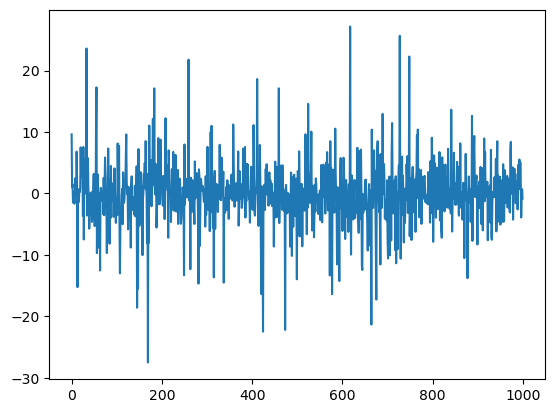

In [41]:
plt.plot(range(1000), samples)
plt.show()